In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [3]:
## audio features and audio cleaning

In [4]:
#Métricas de avaliação geral das separações:

In [5]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from scipy.io.wavfile import write
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import librosa.display
from fastdtw import fastdtw
import scipy.spatial.distance as sp
from scipy.spatial.distance import cosine

/home/giovana/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/tmp/ipykernel_16547/2978522024.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Funções para o filtro de passa-banda
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Parâmetros do filtro
lowcut = 32.0  # Freq. mínima
highcut = 1000.0  # Freq. máxima
fs = 22000      # Taxa de amostragem

#Diretórios onde os audios extraídos foram organizados
base_dir = "./"
output_dir = os.path.join(base_dir, "filtered_outputs")

os.makedirs(output_dir, exist_ok=True)
data = []
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    bass_file = os.path.join(folder_path, "bass.wav")
    guitar_file = os.path.join(folder_path, "other.wav")
    
    if os.path.exists(bass_file):
        audio, sr = librosa.load(bass_file, sr=fs)  
        filtered_audio = apply_bandpass_filter(audio, lowcut, highcut, fs)
        output_file = os.path.join(output_dir, f"{folder}bass.wav")
        write(output_file, sr, (filtered_audio * 32767).astype(np.int16))
        
        duration = librosa.get_duration(y=filtered_audio, sr=sr)
        rms = librosa.feature.rms(y=filtered_audio).mean()
        spectral_centroid = librosa.feature.spectral_centroid(y=filtered_audio, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=filtered_audio, sr=sr).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=filtered_audio).mean()
        
        data.append({
            "Music": folder,
            "Type": "bass",
            "Duration (s)": duration,
            "Sampling Rate (Hz)": sr,
            "RMS Energy": rms,
            "Spectral Centroid": spectral_centroid,
            "Spectral Bandwidth": spectral_bandwidth,
            "Zero Crossing Rate": zero_crossing_rate,
        })
    
    if os.path.exists(guitar_file):
        audio, sr = librosa.load(guitar_file, sr=fs)
        duration = librosa.get_duration(y=audio, sr=sr)
        rms = librosa.feature.rms(y=audio).mean()
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio).mean()
        
        data.append({
            "Music": folder,
            "Type": "guitar",
            "Duration (s)": duration,
            "Sampling Rate (Hz)": sr,
            "RMS Energy": rms,
            "Spectral Centroid": spectral_centroid,
            "Spectral Bandwidth": spectral_bandwidth,
            "Zero Crossing Rate": zero_crossing_rate,
        })

df = pd.DataFrame(data)
output_csv = os.path.join(output_dir, "audio_metrics_with_cover.csv")
df.to_csv(output_csv, index=False)

print(f"Áudios filtrados e analisados salvos em: {output_dir}")
print(f"Dataset com coluna Cover salvo em: {output_csv}")


Áudios filtrados e analisados salvos em: /home/giovana/unmixer/hdemucs_mmi/filtered_outputs
Dataset com coluna Cover salvo em: /home/giovana/unmixer/hdemucs_mmi/filtered_outputs/audio_metrics_with_cover.csv


In [7]:
df

,Music,Type,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate
0,MyNameIsMud,bass,283.097727,22000,0.074527,257.595971,267.515629,0.015600
1,MyNameIsMud,guitar,283.097727,22000,0.040200,2253.720463,1890.193721,0.136460
2,Selfesteem,bass,257.880818,22000,0.078085,235.858130,209.203174,0.014332
3,Selfesteem,guitar,257.880818,22000,0.089328,2315.921336,1897.624473,0.154048
4,Lauren,bass,229.343500,22000,0.142369,240.644841,182.085578,0.015717
...,...,...,...,...,...,...,...,...
57,Anesthesia,guitar,268.678136,22000,0.141290,1892.521354,1501.849124,0.101436
58,LookYourBack,bass,298.515773,22000,0.079489,222.697763,190.840079,0.014191
59,LookYourBack,guitar,298.515773,22000,0.072976,2141.113779,1743.589029,0.140866
60,StairwayToHeaven,bass,482.882182,22000,0.028072,277.837420,226.745955,0.020212


In [8]:
bass_filtered_stats = df[(df['Type'] == 'bass')]
guitar_stats = df[(df['Type'] == 'guitar')]

In [9]:
bass_filtered_stats.describe()

,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate
count,31.000000,31.0,31.000000,31.000000,31.000000,31.000000
mean,257.925779,22000.0,0.085229,235.989247,207.473567,0.015078
std,67.816362,0.0,0.034964,51.599806,44.277490,0.003549
min,166.742500,22000.0,0.016910,154.581933,126.439697,0.009822
25%,206.320932,22000.0,0.062567,202.054049,181.869987,0.012311
50%,257.880818,22000.0,0.078085,235.273312,199.157426,0.014191
75%,283.434409,22000.0,0.113492,267.716695,231.412591,0.017167
max,482.882182,22000.0,0.152795,366.915282,314.104541,0.023817


In [10]:
guitar_stats.describe()

,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate
count,31.000000,31.0,31.000000,31.000000,31.000000,31.000000
mean,257.925779,22000.0,0.075264,1770.480888,1566.009794,0.111019
std,67.816362,0.0,0.025871,311.727839,178.953711,0.026868
min,166.742500,22000.0,0.039163,752.356683,1142.684495,0.036606
25%,206.320932,22000.0,0.055662,1641.674428,1470.438608,0.100155
50%,257.880818,22000.0,0.073933,1768.609791,1536.552618,0.116523
75%,283.434409,22000.0,0.089987,1896.821476,1667.586995,0.129550
max,482.882182,22000.0,0.141290,2315.921336,2003.624881,0.159342


In [11]:
""""
Comparação entre os clusters de guitarras:
Cluster 0: Sons com baixa energia, mais suaves, com frequências médias a altas. A variação de frequências é razoável, e as transições não são muito rápidas. Podem ser sons mais atmosféricos ou com um caráter "brilhante", mas não tão intensos.

Cluster 1: Sons com maior energia, muito concentrados em frequências altas e ricos em harmônicos. Esses sons são mais complexos, com transições rápidas, indicando que podem ser timbres mais percussivos ou com uma textura mais dinâmica e vibrante.

Cluster 2: Sons mais intensos e energéticos, mas com uma ênfase em frequências mais baixas, como graves. A gama de frequências é moderada, e as transições são suaves, o que pode indicar sons de baixo ou timbres graves e contínuos.

Cluster 3: Sons com intensidade razoável, com frequências médias a altas e uma boa diversidade harmônica. As transições são mais suaves, indicando que esses sons podem ser mais melódicos ou harmônicos, mas com uma boa gama de timbres.
"""

'"\nComparação entre os clusters de guitarras:\nCluster 0: Sons com baixa energia, mais suaves, com frequências médias a altas. A variação de frequências é razoável, e as transições não são muito rápidas. Podem ser sons mais atmosféricos ou com um caráter "brilhante", mas não tão intensos.\n\nCluster 1: Sons com maior energia, muito concentrados em frequências altas e ricos em harmônicos. Esses sons são mais complexos, com transições rápidas, indicando que podem ser timbres mais percussivos ou com uma textura mais dinâmica e vibrante.\n\nCluster 2: Sons mais intensos e energéticos, mas com uma ênfase em frequências mais baixas, como graves. A gama de frequências é moderada, e as transições são suaves, o que pode indicar sons de baixo ou timbres graves e contínuos.\n\nCluster 3: Sons com intensidade razoável, com frequências médias a altas e uma boa diversidade harmônica. As transições são mais suaves, indicando que esses sons podem ser mais melódicos ou harmônicos, mas com uma boa gama

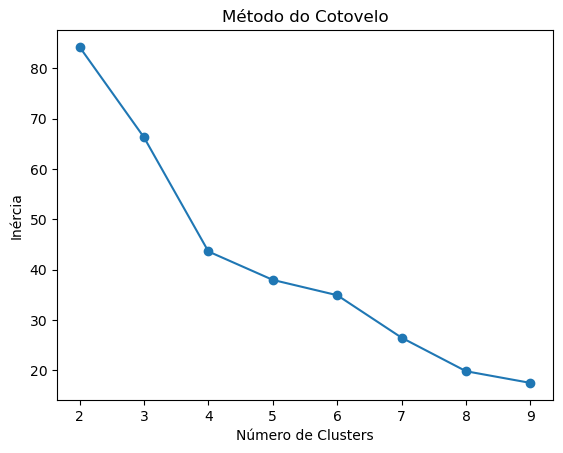

In [12]:
features = guitar_stats[['RMS Energy', 'Spectral Centroid', 'Spectral Bandwidth', 'Zero Crossing Rate']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(features_scaled)
score = silhouette_score(features_scaled, labels)
print(f"Silhouette Score: {score}")
guitar_stats['Cluster'] = labels

Silhouette Score: 0.334250264784619


/tmp/ipykernel_16547/972236123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guitar_stats['Cluster'] = labels


Figura salva em: /home/giovana/unmixer/hdemucs_mmi/Imagens/ClustersGuitarra.pdf


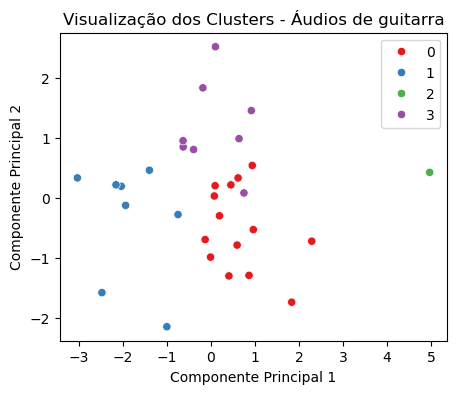

In [14]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)

plt.figure(figsize=(5, 4))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='Set1')
plt.title('Visualização dos Clusters - Áudios de guitarra')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

output_file_path = "./ClustersGuitarra.pdf"
plt.savefig(output_file_path, format='pdf') 

print(f"Figura salva em: {output_file_path}")
plt.show()

In [15]:
guitar_stats[guitar_stats['Cluster'] == 1]

,Music,Type,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate,Cluster
1,MyNameIsMud,guitar,283.097727,22000,0.040200,2253.720463,1890.193721,0.136460,1
3,Selfesteem,guitar,257.880818,22000,0.089328,2315.921336,1897.624473,0.154048,1
17,SmellsLikeTeenSpirit,guitar,278.407273,22000,0.071507,2191.153288,1595.252231,0.159342,1
35,yyz,guitar,266.240000,22000,0.069762,1901.121599,1660.097337,0.120502,1
45,tangerine,guitar,190.380409,22000,0.039163,1811.485875,2003.624881,0.097728,1
47,HotForTeacher,guitar,282.795864,22000,0.087644,2070.051700,1675.485826,0.131516,1
49,vanhalen,guitar,227.857455,22000,0.076975,2238.824805,1675.076653,0.150008,1
59,LookYourBack,guitar,298.515773,22000,0.072976,2141.113779,1743.589029,0.140866,1


In [16]:
cluster_summary = guitar_stats.groupby('Cluster')[['RMS Energy', 'Spectral Centroid', 'Spectral Bandwidth', 'Zero Crossing Rate']].mean()
print(cluster_summary)

         RMS Energy  Spectral Centroid  Spectral Bandwidth  Zero Crossing Rate
Cluster                                                                       
0          0.059180        1640.829172         1474.408277            0.105462
1          0.068444        2115.424106         1767.618019            0.136309
2          0.085750         752.356683         1142.684495            0.036606
3          0.108919        1779.693698         1577.619886            0.104757


In [17]:
'''
Comparações de clusters de baixo:
Cluster 0: Sons de intensidade moderada, com tonalidade mais grave e suave, e baixa complexidade harmônica.
Cluster 1: Sons energéticos e com maior concentração em frequências mais altas, com uma gama harmônica relativamente mais ampla e transições mais rápidas.
Cluster 2: Sons intensos, concentrados em frequências graves, com baixa variação harmônica e transições suaves.
Cluster 3: Sons muito suaves, com tonalidade brilhante e alta gama harmônica. Transições rápidas indicam possível natureza percussiva ou de ruído.
Cluster 4: Sons moderadamente intensos, com tonalidade mais brilhante e uma gama de frequências mais ampla do que no Cluster 0, mas menos complexa do que no Cluster 3.
Cluster 5: Sons intensos e brilhantes, com uma boa diversidade harmônica e transições moderadas.
'''

'\nComparações de clusters de baixo:\nCluster 0: Sons de intensidade moderada, com tonalidade mais grave e suave, e baixa complexidade harmônica.\nCluster 1: Sons energéticos e com maior concentração em frequências mais altas, com uma gama harmônica relativamente mais ampla e transições mais rápidas.\nCluster 2: Sons intensos, concentrados em frequências graves, com baixa variação harmônica e transições suaves.\nCluster 3: Sons muito suaves, com tonalidade brilhante e alta gama harmônica. Transições rápidas indicam possível natureza percussiva ou de ruído.\nCluster 4: Sons moderadamente intensos, com tonalidade mais brilhante e uma gama de frequências mais ampla do que no Cluster 0, mas menos complexa do que no Cluster 3.\nCluster 5: Sons intensos e brilhantes, com uma boa diversidade harmônica e transições moderadas.\n'

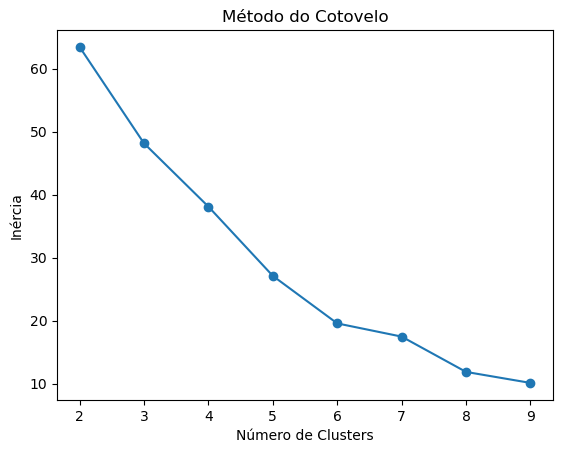

In [18]:
features = bass_filtered_stats[['RMS Energy', 'Spectral Centroid', 'Spectral Bandwidth', 'Zero Crossing Rate']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [19]:
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(features_scaled)
score = silhouette_score(features_scaled, labels)
print(f"Silhouette Score: {score}")
bass_filtered_stats['Cluster'] = labels

Silhouette Score: 0.36886255502977616


/tmp/ipykernel_16547/628295994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bass_filtered_stats['Cluster'] = labels


Figura salva em: /home/giovana/unmixer/hdemucs_mmi/Imagens/ClustersBaixo.pdf


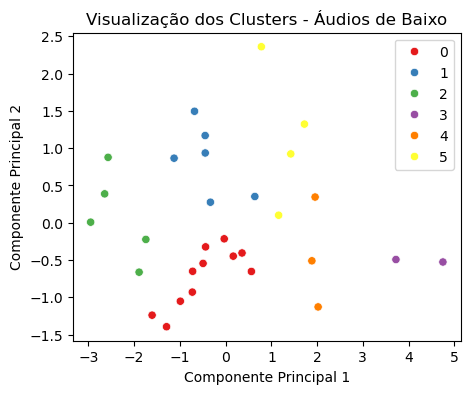

In [20]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)

plt.figure(figsize=(5, 4))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='Set1')
plt.title('Visualização dos Clusters - Áudios de Baixo')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
output_file_path = "./ClustersBaixo.pdf" 
plt.savefig(output_file_path, format='pdf')  
print(f"Figura salva em: {output_file_path}")
plt.show()

In [21]:
bass_filtered_stats[bass_filtered_stats['Cluster'] == 0]

,Music,Type,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate,Cluster
2,Selfesteem,bass,257.880818,22000,0.078085,235.858130,209.203174,0.014332,0
6,Limelight,bass,260.853000,22000,0.056235,251.711623,234.429926,0.013749,0
10,DontFearTheReaper,bass,308.987955,22000,0.060941,195.624038,185.077420,0.011952,0
22,FairiesWearBoots,bass,374.375364,22000,0.072688,219.451064,189.574565,0.013771,0
24,Paranoid,bass,166.742500,22000,0.070046,210.553076,208.983337,0.011255,0
28,ICouldHaveLied,bass,244.436500,22000,0.053925,180.113267,164.028580,0.012375,0
40,DontCry,bass,283.771091,22000,0.062524,170.687175,157.311144,0.012052,0
48,vanhalen,bass,227.857455,22000,0.067814,241.086110,218.815001,0.013870,0
50,DaniCalifornia,bass,287.672045,22000,0.062610,208.484059,181.654395,0.013084,0
54,UnderTheBridge,bass,264.684273,22000,0.069274,236.799358,199.157426,0.017043,0


In [22]:
cluster_summary = bass_filtered_stats.groupby('Cluster')[['RMS Energy', 'Spectral Centroid', 'Spectral Bandwidth', 'Zero Crossing Rate']].mean()
print(cluster_summary)

         RMS Energy  Spectral Centroid  Spectral Bandwidth  Zero Crossing Rate
Cluster                                                                       
0          0.066694         215.733242          194.461368            0.013425
1          0.117612         234.738999          198.286494            0.015218
2          0.113360         168.980492          149.647630            0.010915
3          0.023014         353.318314          301.051836            0.022878
4          0.051327         286.735727          231.798922            0.020102
5          0.108998         280.605181          264.286998            0.016951


In [23]:
bass_clusters = bass_filtered_stats.groupby("Cluster")["Music"].apply(set).reset_index()
cluster_mapping = {}

for _, row in bass_clusters.iterrows():
    cluster_bass = row["Cluster"]
    music_set = row["Music"]
    filtered_guitar = guitar_stats[guitar_stats["Music"].isin(music_set)]
    cluster_counts = filtered_guitar["Cluster"].value_counts()
    cluster_mapping[cluster_bass] = cluster_counts
for cluster, distribution in cluster_mapping.items():
    print(f"Cluster {cluster} em bass_filtered_stats:")
    print(distribution)
    print("-" * 40)

Cluster 0 em bass_filtered_stats:
Cluster
0    8
1    3
Name: count, dtype: int64
----------------------------------------
Cluster 1 em bass_filtered_stats:
Cluster
3    3
0    2
2    1
Name: count, dtype: int64
----------------------------------------
Cluster 2 em bass_filtered_stats:
Cluster
0    2
3    2
1    1
Name: count, dtype: int64
----------------------------------------
Cluster 3 em bass_filtered_stats:
Cluster
1    1
3    1
Name: count, dtype: int64
----------------------------------------
Cluster 4 em bass_filtered_stats:
Cluster
1    2
0    1
Name: count, dtype: int64
----------------------------------------
Cluster 5 em bass_filtered_stats:
Cluster
3    2
1    1
0    1
Name: count, dtype: int64
----------------------------------------


In [24]:
bass_filtered_stats[bass_filtered_stats['Cluster'] == 0]

,Music,Type,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate,Cluster
2,Selfesteem,bass,257.880818,22000,0.078085,235.858130,209.203174,0.014332,0
6,Limelight,bass,260.853000,22000,0.056235,251.711623,234.429926,0.013749,0
10,DontFearTheReaper,bass,308.987955,22000,0.060941,195.624038,185.077420,0.011952,0
22,FairiesWearBoots,bass,374.375364,22000,0.072688,219.451064,189.574565,0.013771,0
24,Paranoid,bass,166.742500,22000,0.070046,210.553076,208.983337,0.011255,0
28,ICouldHaveLied,bass,244.436500,22000,0.053925,180.113267,164.028580,0.012375,0
40,DontCry,bass,283.771091,22000,0.062524,170.687175,157.311144,0.012052,0
48,vanhalen,bass,227.857455,22000,0.067814,241.086110,218.815001,0.013870,0
50,DaniCalifornia,bass,287.672045,22000,0.062610,208.484059,181.654395,0.013084,0
54,UnderTheBridge,bass,264.684273,22000,0.069274,236.799358,199.157426,0.017043,0


In [25]:
guitar_stats[guitar_stats['Cluster'] == 0]

,Music,Type,Duration (s),Sampling Rate (Hz),RMS Energy,Spectral Centroid,Spectral Bandwidth,Zero Crossing Rate,Cluster
7,Limelight,guitar,260.853000,22000,0.068445,1787.438613,1366.980746,0.130297,0
11,DontFearTheReaper,guitar,308.987955,22000,0.073933,1660.672260,1421.031020,0.119288,0
15,santeria,guitar,183.228682,22000,0.044199,1658.562163,1600.659435,0.099298,0
19,IfYouWantMeToStay,guitar,247.385409,22000,0.046560,1820.717391,1425.388013,0.130374,0
23,FairiesWearBoots,guitar,374.375364,22000,0.052528,1694.855342,1491.306450,0.101013,0
25,Paranoid,guitar,166.742500,22000,0.041998,1664.742861,1514.792549,0.088844,0
27,Rooster,guitar,377.347500,22000,0.065904,1763.747592,1526.948509,0.107835,0
29,ICouldHaveLied,guitar,244.436500,22000,0.040043,1348.849219,1603.356713,0.064046,0
37,WetSand,guitar,309.847091,22000,0.074307,1711.223902,1536.552618,0.116923,0
39,ByTheWay,guitar,217.013727,22000,0.076485,1637.685635,1278.044213,0.117492,0


In [26]:
bass_filtered_stats.to_csv("./dadosOriginaisBaixo.csv")

In [27]:
guitar_stats.to_csv("./dadosOriginaisGuitarra.csv")

In [28]:
## Análise dos covers

In [29]:
# Função para calcular o deslocamento de tempo (DTW) e a semelhança baseada na distância do cosseno
def calculate_time_shift_and_similarity(original_audio, cover_audio, sr_original, sr_cover):
    chroma_classic = librosa.feature.chroma_cens(y=original_audio, sr=sr_original)
    chroma_cover = librosa.feature.chroma_cens(y=cover_audio, sr=sr_cover)
    distance, path = fastdtw(chroma_cover.T, chroma_classic.T, dist=sp.cosine)
    time_shifts = []
    for i, j in path:
        time_original = i / sr_original 
        time_cover = j / sr_cover      
        time_shifts.append(time_cover - time_original)
    average_time_shift = np.mean(time_shifts)
    return distance, average_time_shift, time_shifts

base_dir = "./hdemucs_mmi"
output_dir = os.path.join(base_dir, "filtered_outputs")

data = []
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    
    for file_type in ["bass", "other"]:  
        original_file = os.path.join(folder_path, f"{file_type}.wav")
        
        if not os.path.exists(original_file):
            continue
        cover_folder = [os.path.join(folder_path, subfolder) for subfolder in os.listdir(folder_path) if 'Cover' in subfolder]
        
        if cover_folder:
            cover_folder = cover_folder[0] 
            cover_file = os.path.join(cover_folder, f"{file_type}.wav")
            if os.path.exists(cover_file):
                original_audio, sr_original = librosa.load(original_file, sr=22000)
                cover_audio, sr_cover = librosa.load(cover_file, sr=22000)
                dtw_distance, avg_time_shift, time_shifts = calculate_time_shift_and_similarity(
                    original_audio, cover_audio, sr_original, sr_cover
                )
                data.append({
                    "Music": folder,
                    "Type": file_type,
                    "Cover": 1 if 'Cover' in folder else 0,
                    "DTW Distance": dtw_distance,
                    "Time Shift": avg_time_shift
                })

df1 = pd.DataFrame(data)
output_csv = os.path.join(output_dir, "dtw_distance_time_shifts_and_similarity.csv")
df.to_csv(output_csv, index=False)

print(df1)

/home/giovana/anaconda3/lib/python3.10/site-packages/scipy/spatial/distance.py:622: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


                   Music   Type  Cover  DTW Distance  Time Shift
0            MyNameIsMud   bass      0   1138.833655   -0.024478
1             Selfesteem  other      0    701.460615    0.001067
2                 Lauren   bass      0   1005.935554   -0.000715
3              Limelight   bass      0   1306.074708    0.007061
4                 RUMine  other      0    373.005543   -0.001017
5      DontFearTheReaper   bass      0   1014.791469   -0.003379
6             DanceDance  other      0    248.249392   -0.002531
7               santeria  other      0    598.257403   -0.005384
8   SmellsLikeTeenSpirit  other      0    772.231922   -0.034567
9      IfYouWantMeToStay   bass      0   1211.737155    0.016200
10        MiseryBusiness  other      0    251.701629   -0.000190
11      FairiesWearBoots  other      0   1767.564359   -0.011418
12              Paranoid  other      0    486.935451   -0.004938
13               Rooster  other      0   1439.466028   -0.002443
14        ICouldHaveLied 

In [30]:
df1.describe()

,Cover,DTW Distance,Time Shift
count,31.0,31.000000,31.000000
mean,0.0,885.312429,-0.003154
std,0.0,467.848635,0.014242
min,0.0,193.611536,-0.034567
25%,0.0,570.269670,-0.008990
50%,0.0,772.231922,-0.002443
75%,0.0,1175.285405,-0.000153
max,0.0,2024.311055,0.035169


Distância DTW entre o chroma do original e do cover: 1524.134882186154
Alinhamento médio das notas (em segundos): 0.03516921704965492
As notas no cover estão adiantadas em média.
Figura salva em: /home/giovana/unmixer/hdemucs_mmi/Imagens/deslocamentoDtw.pdf


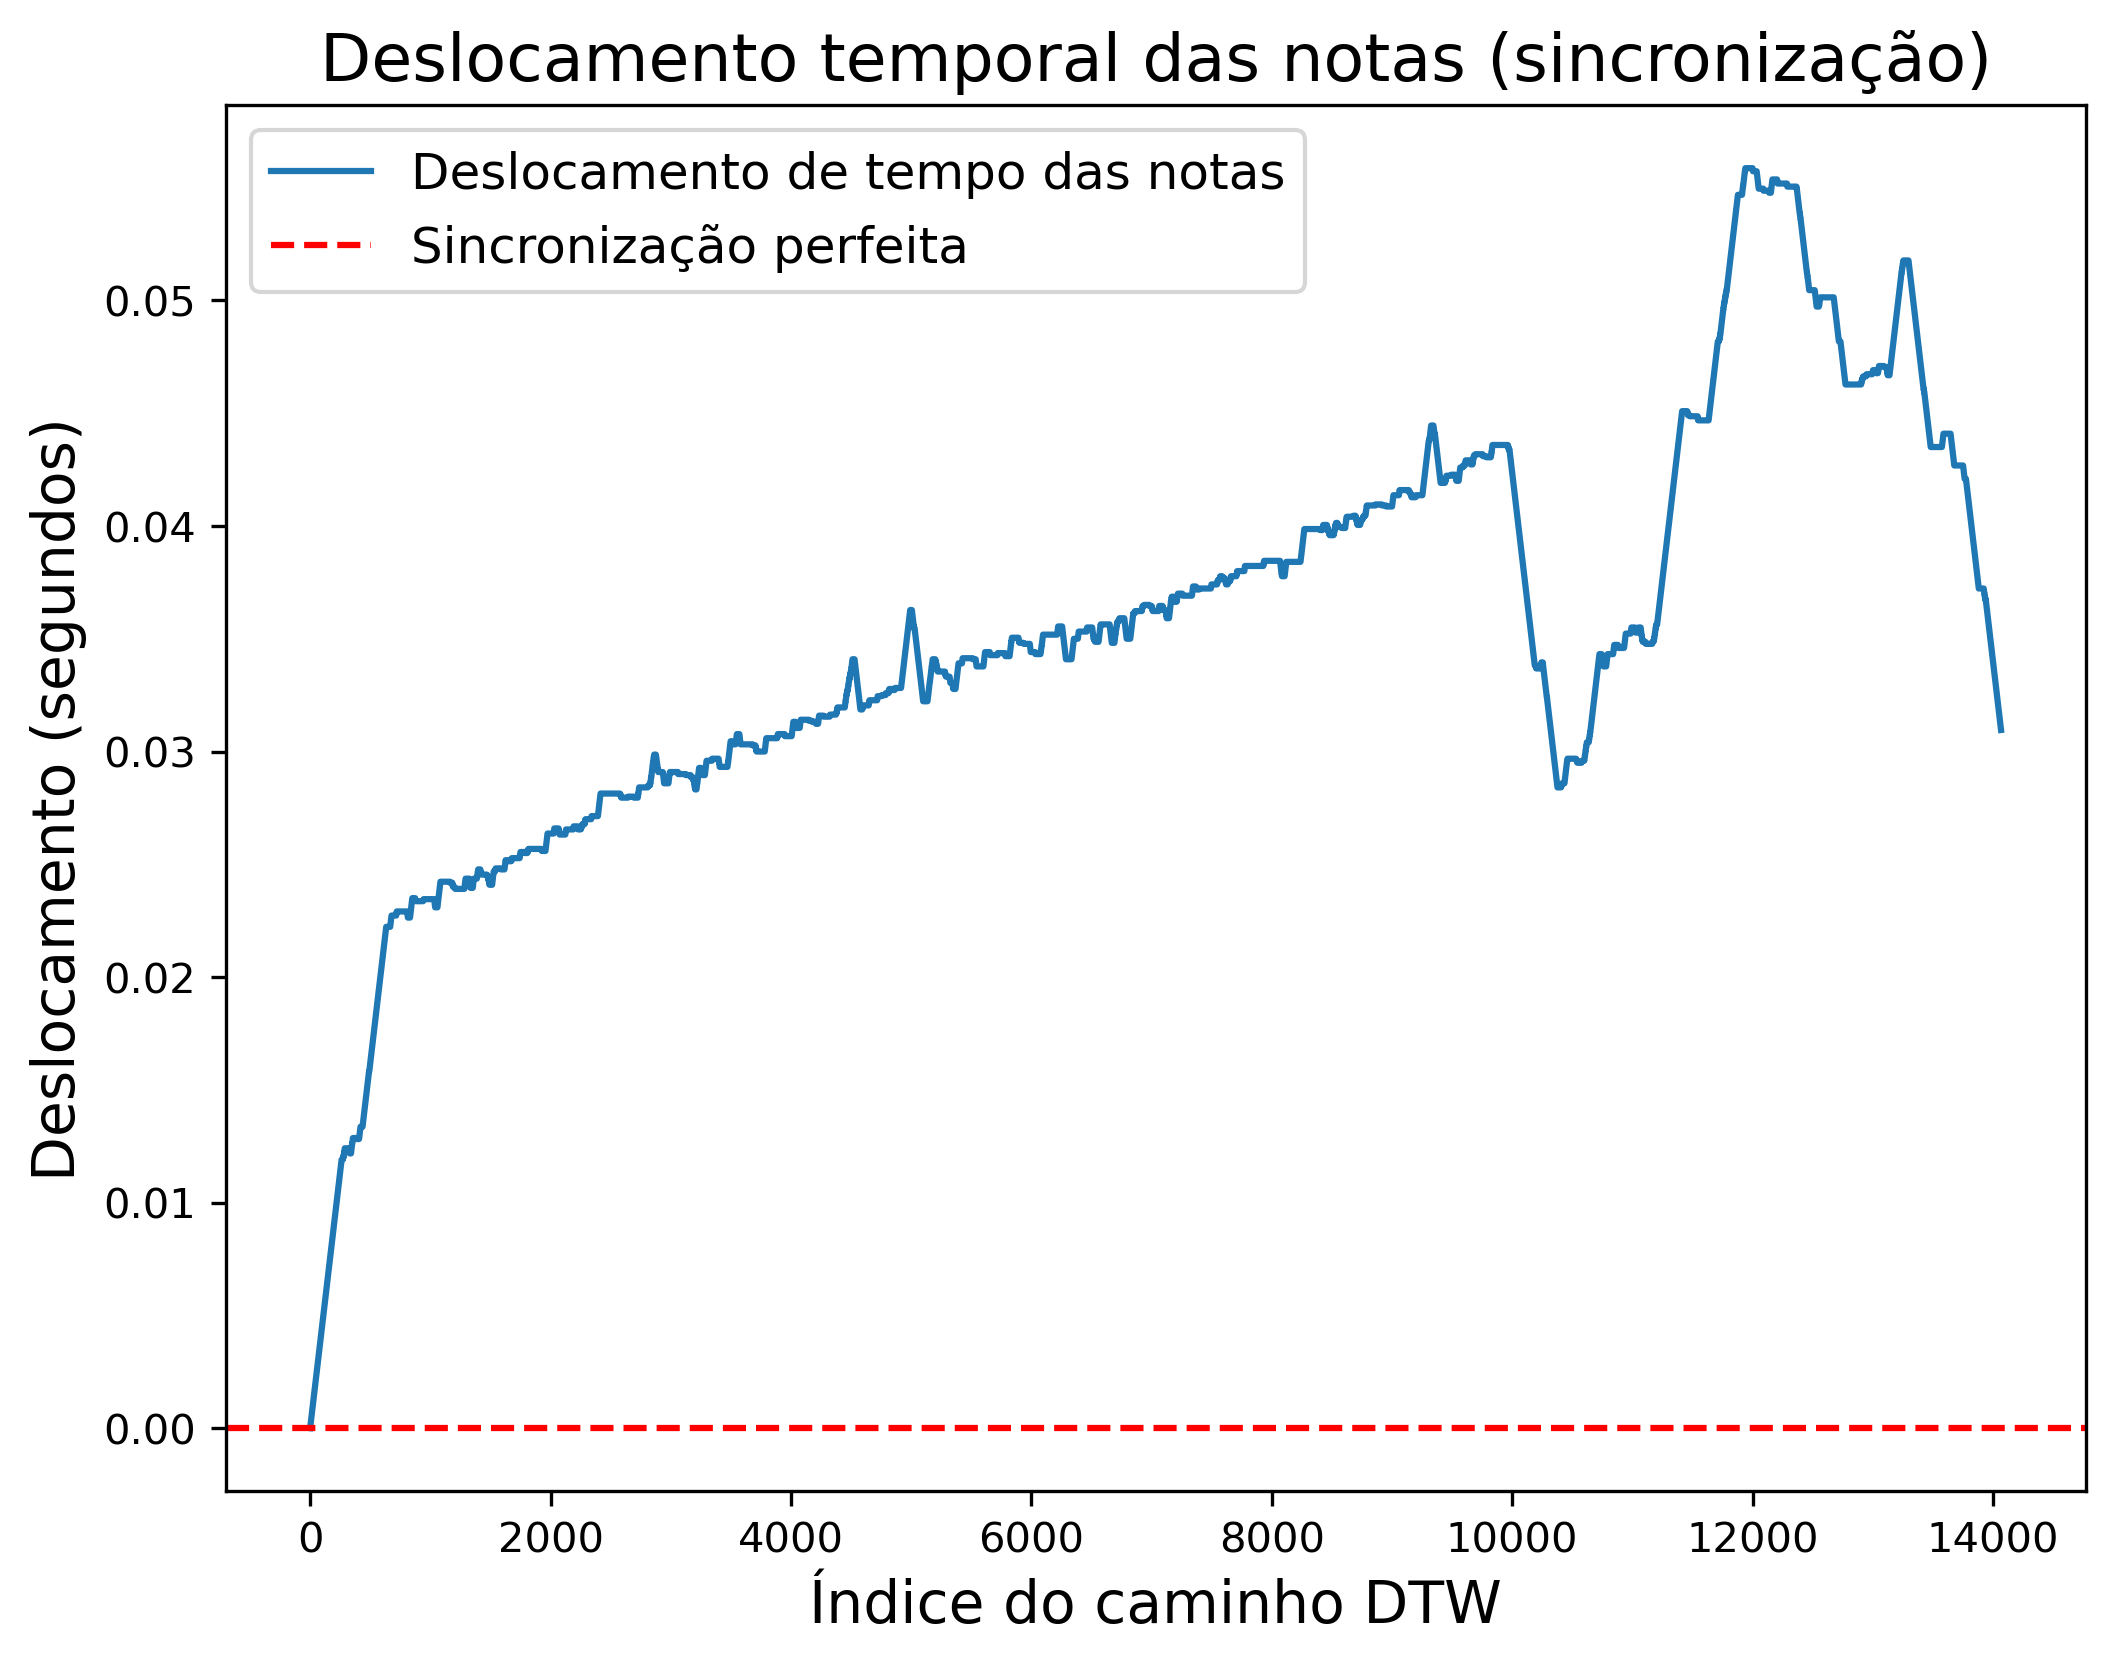

In [31]:
original_audio, sr_original = librosa.load('./DaniCalifornia/bass.wav', sr=22000)
cover_audio, sr_cover = librosa.load('./DaniCaliforniaCover/bass.wav',sr=22000)
chroma_classic = librosa.feature.chroma_cens(y=original_audio, sr=sr_original)
chroma_cover = librosa.feature.chroma_cens(y=cover_audio, sr=sr_cover)

distance, path = fastdtw(chroma_cover.T, chroma_classic.T, dist=sp.cosine)
print(f'Distância DTW entre o chroma do original e do cover: {distance}')

time_shifts = []
for i, j in path:
    time_original = i / sr_original  
    time_cover = j / sr_cover     
    time_shifts.append(time_cover - time_original)
average_time_shift = np.mean(time_shifts)
print(f'Alinhamento médio das notas (em segundos): {average_time_shift}')

if average_time_shift > 0:
    print("As notas no cover estão adiantadas em média.")
elif average_time_shift < 0:
    print("As notas no cover estão atrasadas em média.")
else:
    print("As notas estão perfeitamente sincronizadas.")

plt.figure(figsize=(8, 6), dpi=300)  
plt.plot(time_shifts, label='Deslocamento de tempo das notas')
plt.axhline(0, color='r', linestyle='--', label='Sincronização perfeita')

plt.title('Deslocamento temporal das notas (sincronização)', fontsize=16)  
plt.xlabel('Índice do caminho DTW', fontsize=14)  
plt.ylabel('Deslocamento (segundos)', fontsize=14)  

plt.legend(fontsize=12)
output_file_path = "./deslocamentoDtw.pdf"
plt.savefig(output_file_path, format='pdf')  

print(f"Figura salva em: {output_file_path}")
plt.show()

In [32]:
## Exemplo de analise para uma musica especifica

In [33]:
original_audio, sr_original = librosa.load('./DaniCalifornia/bass.wav', sr=22000)
cover_audio, sr_cover = librosa.load('./DaniCaliforniaCover/bass.wav',sr=22000)
original_mfcc = librosa.feature.mfcc(y=original_audio, sr=sr_original)
cover_mfcc = librosa.feature.mfcc(y=cover_audio, sr=sr_cover)
mfcc_similarity = 1 - cosine(np.mean(original_mfcc, axis=1), np.mean(cover_mfcc, axis=1))
print(f"Similaridade de Timbre (MFCC Cosine Similarity): {mfcc_similarity}")


original_pitch, _ = librosa.core.piptrack(y=original_audio, sr=sr_original)
cover_pitch, _ = librosa.core.piptrack(y=cover_audio, sr=sr_cover)
original_pitch_mean = np.mean(original_pitch, axis=1)
cover_pitch_mean = np.mean(cover_pitch, axis=1)
afina_similaridade = 1 - cosine(original_pitch_mean, cover_pitch_mean)
print(f"Similaridade de Afinação (Cosine Similarity entre pitches): {afina_similaridade}")

Similaridade de Timbre (MFCC Cosine Similarity): 0.9977865815162659
Similaridade de Afinação (Cosine Similarity entre pitches): 0.8271707892417908


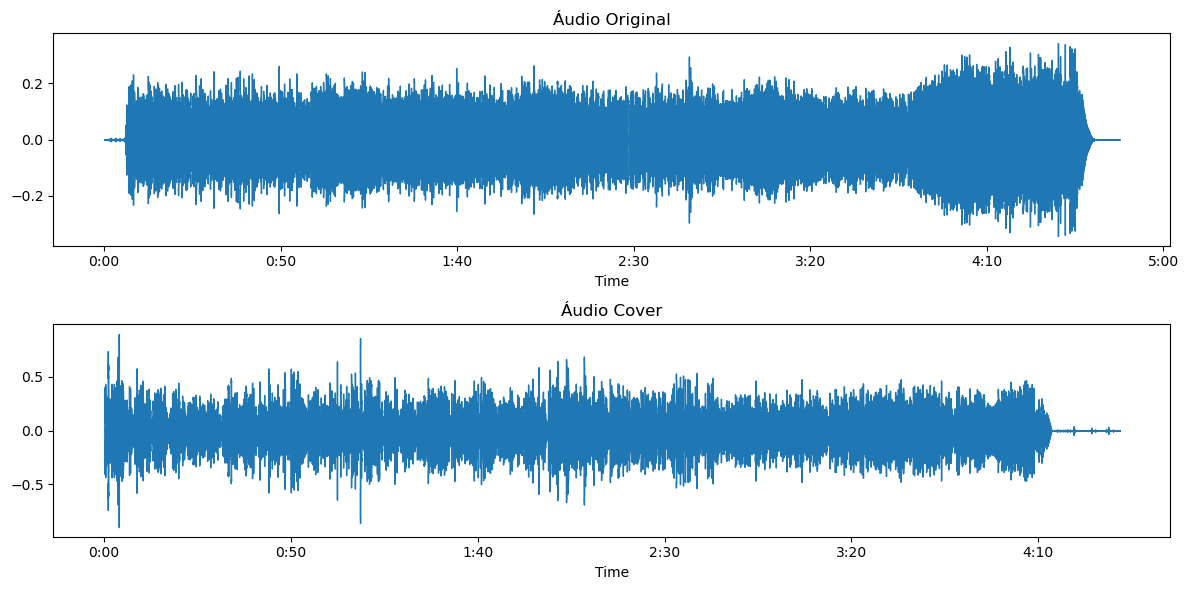

In [34]:
def plot_audio_waveform(original_audio, cover_audio, sr_original, sr_cover, output_pdf_path):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original_audio, sr=sr_original)
    plt.title('Áudio Original')
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(cover_audio, sr=sr_cover)
    plt.title('Áudio Cover')
    plt.tight_layout()
    plt.savefig(output_pdf_path, format='pdf')
output_pdf_path = "./waveForms.pdf"
plot_audio_waveform(original_audio, cover_audio, sr_original, sr_cover, output_pdf_path)

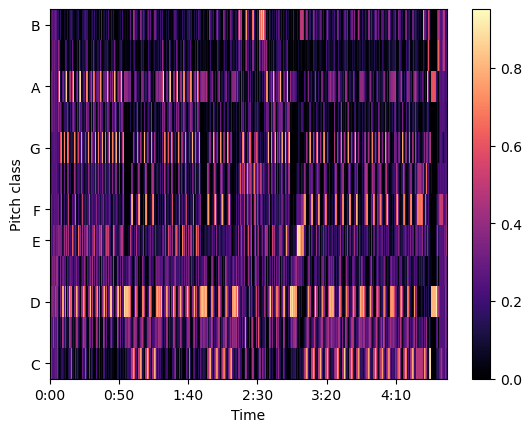

In [35]:
chroma_classic = librosa.feature.chroma_cens(y = original_audio, sr=sr_original)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)
pdf_filename = "./chromagramaOriginal.pdf"
fig.savefig(pdf_filename, format='pdf')

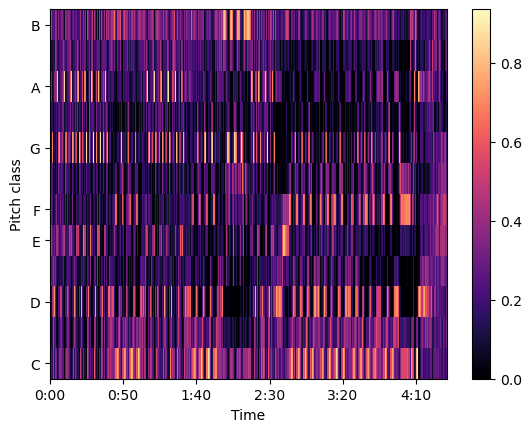

In [36]:
chroma_amy = librosa.feature.chroma_cens(y = cover_audio, sr=sr_cover)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)
pdf_filename = "./chromagramaCover.pdf"
fig.savefig(pdf_filename, format='pdf')

In [37]:
##Audio quality

In [38]:
def calculate_similarity(original_audio, cover_audio, sr_original, sr_cover):
    original_mfcc = librosa.feature.mfcc(y=original_audio, sr=sr_original)
    cover_mfcc = librosa.feature.mfcc(y=cover_audio, sr=sr_cover)
    mfcc_similarity = 1 - cosine(np.mean(original_mfcc, axis=1), np.mean(cover_mfcc, axis=1))
    original_pitch, _ = librosa.core.piptrack(y=original_audio, sr=sr_original)
    cover_pitch, _ = librosa.core.piptrack(y=cover_audio, sr=sr_cover)
    original_pitch_mean = np.mean(original_pitch, axis=1)
    cover_pitch_mean = np.mean(cover_pitch, axis=1)
    pitch_similarity = 1 - cosine(original_pitch_mean, cover_pitch_mean)

    return mfcc_similarity, pitch_similarity

base_dir = "./hdemucs_mmi"
data = []
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    
    for file_type in ["bass", "other"]:  
        original_file = os.path.join(folder_path, f"{file_type}.wav")
        
        if not os.path.exists(original_file):
            continue
        cover_folders = [os.path.join(folder_path, subfolder) for subfolder in os.listdir(folder_path) if 'Cover' in subfolder]
        
        if cover_folders:
            cover_folder = cover_folders[0] 
            cover_file = os.path.join(cover_folder, f"{file_type}.wav")
            if os.path.exists(cover_file):
                original_audio, sr_original = librosa.load(original_file, sr=22000)
                cover_audio, sr_cover = librosa.load(cover_file, sr=22000)
                mfcc_similarity, pitch_similarity = calculate_similarity(original_audio, cover_audio, sr_original, sr_cover)
                data.append({
                    "Music": folder,
                    "Type": file_type,
                    "MFCC Similarity": mfcc_similarity,
                    "Pitch Similarity": pitch_similarity
                })

df_similarity = pd.DataFrame(data)
output_dir = os.path.join(base_dir, "filtered_outputs")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "similarity_analysis.csv")
df_similarity.to_csv(output_file, index=False)
print(df_similarity)

                   Music   Type  MFCC Similarity  Pitch Similarity
0            MyNameIsMud   bass         0.997268          0.836380
1             Selfesteem  other         0.966746          0.914910
2                 Lauren   bass         0.998065          0.957042
3              Limelight   bass         0.993099          0.616014
4                 RUMine  other         0.991967          0.913879
5      DontFearTheReaper   bass         0.994581          0.932888
6             DanceDance  other         0.991177          0.902218
7               santeria  other         0.981771          0.874652
8   SmellsLikeTeenSpirit  other         0.978201          0.949019
9      IfYouWantMeToStay   bass         0.998533          0.836510
10        MiseryBusiness  other         0.987906          0.983895
11      FairiesWearBoots  other         0.986023          0.792066
12              Paranoid  other         0.963680          0.811984
13               Rooster  other         0.996348          0.91

In [39]:
df_similarity.describe()

,MFCC Similarity,Pitch Similarity
count,31.000000,31.000000
mean,0.987132,0.810583
std,0.013564,0.188561
min,0.936311,0.127617
25%,0.983897,0.778454
50%,0.991177,0.874652
75%,0.996412,0.923980
max,0.998533,0.983895
